# Tim Allen: Design and Research Craftsman

### "What’s the least amount of fidelity you can give to an idea that allows people to understand that it’s a great idea?" —via [Finding Our Way](https://findingourway.design/2023/04/12/38-the-craft-led-design-executive-ft-tim-allen/)

### We think across the food, cooking, and groceries space with the Tim Allen

Instructions for getting cozy with this AI recipe are on the [GitHub page's README](https://aka.ms/CAIK-repo). 

# 🧑‍🍳 Recipe for AI-driven 

- ~500 tokens from COMPLETION Pre-trained Foundation Model
- borrow a little multi-modal AI model energy from GPT-4V

> [!IMPORTANT]
> You will need an [.Net 7 SDK](https://dotnet.microsoft.com/en-us/download) and [Polyglot](https://marketplace.visualstudio.com/items?itemName=ms-dotnettools.dotnet-interactive-vscode) to get started with this notebook using .Net Interactive

# Gather the core tools 🧰

When running the following cell, if asked to "select your kernel" (note this will be referring to the Jupyter notebook's kernel and not Semantic Kernel) then choose `.NET Interactive` from the available menu options.

In [1]:
// Load some helper functions, e.g. to load values from settings.json
#!import ../config/Settings.cs 

#r "nuget: Microsoft.SemanticKernel, 1.0.0-beta3"
#r "nuget: System.Linq.Async, 6.0.1"

Installed Packages Microsoft.SemanticKernel, 1.0.0-beta3 System.Linq.Async, 6.0.1

# Fire up a kernel with TWO models 🔥

In [2]:
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Orchestration;
using Microsoft.SemanticKernel.Plugins.Memory;
using Microsoft.SemanticKernel.Connectors.AI.OpenAI;

var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

var memoryBuilder = new MemoryBuilder();
var kernelBuilder = new KernelBuilder();

// gpt-3.5-turbo is used by default
model = "gpt-4";

Console.WriteLine($"Using 🧱 Model: {model}");

if (useAzureOpenAI)
{
    memoryBuilder.WithAzureTextEmbeddingGenerationService("text-embedding-ada-002", azureEndpoint, apiKey);
    kernelBuilder.WithAzureChatCompletionService(model, azureEndpoint, apiKey);
}
else
{
    memoryBuilder.WithOpenAITextEmbeddingGenerationService("text-embedding-ada-002", apiKey);
    kernelBuilder.WithOpenAIChatCompletionService(model, apiKey, orgId);
}

memoryBuilder.WithMemoryStore(new VolatileMemoryStore());

var kernel = kernelBuilder.Build();
var memory = memoryBuilder.Build();

Using 🧱 Model: gpt-4


## A 👁️ multi-modal model might be fun to add to the mix

![](imgs/grocer.jpg)

Let's use a photo I shot at my nearby supermarket, and ask GPT-4V what's in the image.

![](imgs/grocergpt4v.png)

General access to GPT-4V isn't available by API yet, so we're just simulating it here.

In [3]:
var vizResult = @"
* Asparagus 
* Artichokes 
* Eggplants
* Yellow squashes
* Zucchinis
* Butternut squashes 
* Green beans
";

# Generate embeddings for later 🧲 gathering

In [4]:
const string MemoryCollectionName = "preferences";

string[] notes = { 
    "for breakfast, meals with eggs are preferred and low salt",
    "for lunch, a meal with less than 300 calories is best",
    "for dinner, definitely offer dessert"
};

for (int i = 0; i < notes.Length; i++)
{
    await memory.SaveInformationAsync(MemoryCollectionName, id: $"note{i}", text: notes[i]);
}

# You can always 🤔 look up what your visitor prefers

In [5]:
var q = "breakfast";

var response = await memory.SearchAsync(MemoryCollectionName, q).FirstOrDefaultAsync();
var mealPreference = response?.Metadata.Text;
Console.WriteLine($"{q}\n> {mealPreference}");

breakfast
> for breakfast, meals with eggs are preferred and low salt


## Now we have enough information to get 🧑‍🍳 cooking

Let's add the inventory of what's in my fridge (that we could get from a 🔌 Plugin) to what we know about our world. And let's use the image snapshot of what we can get at our local grocer.

In [6]:
var inMyFridgeAndPantry = @"
milk, eggs, butter, chicken, cheese, yogurt, salt, pepper, sugar, olive oil, flour
";

Console.WriteLine($"Meal preference: {mealPreference}\n");
Console.WriteLine($"In my fridge and pantry:\n{inMyFridgeAndPantry}");
Console.WriteLine($"Available at my grocer: {vizResult}");

Meal preference: for breakfast, meals with eggs are preferred and low salt

In my fridge and pantry:

milk, eggs, butter, chicken, cheese, yogurt, salt, pepper, sugar, olive oil, flour

Available at my grocer: 
* Asparagus 
* Artichokes 
* Eggplants
* Yellow squashes
* Zucchinis
* Butternut squashes 
* Green beans



## Let's 🤔 determine what to make ...

In [7]:
using Microsoft.SemanticKernel.Orchestration;

var pluginsSKDirectory = "plugins-sk";

var myFunctions = kernel.ImportSemanticFunctionsFromDirectory(pluginsSKDirectory, "CookingForReal");

var myContext = new ContextVariables(); 

myContext.Set("grocer", vizResult); 
myContext.Set("available", inMyFridgeAndPantry);
myContext.Set("mealtype", mealPreference); 

var myResult = await kernel.RunAsync(myContext,myFunctions["MealSuggester"]);
var mealString = myResult.GetValue<string>();

Console.WriteLine(mealString);

We will prepare a light and healthy scrambled eggs with sautéed vegetables for breakfast. The eggs will be cooked with a touch of milk and butter, and served with a side of sautéed asparagus, zucchini, and green beans, seasoned with a minimal amount of salt and pepper. If desired, a sprinkle of cheese can be added for extra flavor.


## Let's go 🛒 shopping 

In [8]:
var myContext = new ContextVariables(); 

myContext.Set("grocer", vizResult); 
myContext.Set("available", inMyFridgeAndPantry);
myContext.Set("themeal", mealString); 

var myResult = await kernel.RunAsync(myContext,myFunctions["ShoppingSuggester"]);
var resultString = myResult.GetValue<string>();

Console.WriteLine(resultString);

Based on the ingredients you already have in your kitchen and the recipe you're planning to make, you will need to pick up the following items from the grocer:

- Asparagus
- Zucchinis
- Green beans

You already have all the other ingredients you need for your recipe in your kitchen.


# Plate the partially finished meal 🍽️

Let's ready an image generation model ...

In [9]:
#r "nuget: SkiaSharp, 2.88.3"

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.AI.ImageGeneration; 
using Microsoft.SemanticKernel.AI.Embeddings;
using Microsoft.SemanticKernel.AI.Embeddings.VectorOperations;
using Microsoft.SemanticKernel.Connectors.AI.OpenAI;

// Load OpenAI credentials from config/settings.json
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

// Configure the three AI features: text embedding (using Ada), text completion (using DaVinci 3), image generation (DALL-E 2)
var builder = new KernelBuilder();

if(useAzureOpenAI)
{
    builder.WithAzureOpenAIImageGenerationService(azureEndpoint, apiKey);
}
else
{
    builder.WithOpenAIImageGenerationService(apiKey, orgId);
}
   
var kernel = builder.Build();

// Get AI service instance used to generate images
var dallE = kernel.GetService<IImageGeneration>();

Installed Packages SkiaSharp, 2.88.3

Loading extensions from `/Users/johnmaeda/.nuget/packages/skiasharp/2.88.3/interactive-extensions/dotnet/SkiaSharp.DotNet.Interactive.dll`

And let's render that meal we were talking about ...

In [10]:
#!import ../config/SkiaUtils.cs

using System;
using System.Threading.Tasks;
using Microsoft.Extensions.Configuration;
using Microsoft.SemanticKernel.Connectors.AI.OpenAI;
using System.IO;
using System.Net.Http;

HttpClient httpClient = new HttpClient();

async Task DownloadImageAsync(string uri, string localPath)
{
    using (HttpResponseMessage response = await httpClient.GetAsync(uri))
    {
        response.EnsureSuccessStatusCode();

        using (Stream contentStream = await response.Content.ReadAsStreamAsync(), 
                fileStream = new FileStream(localPath, FileMode.Create, FileAccess.Write, FileShare.None))
        {
            await contentStream.CopyToAsync(fileStream);
        }
    }
}

var myContext = new ContextVariables(); 

myContext.Set("mealdescription", mealString); 

var myResult = await kernel.RunAsync(myContext,myFunctions["PlatingAssistant"]);
var dalleString = myResult.GetValue<string>();

Console.WriteLine(dalleString);

var imageDescription = dalleString;
var image = await dallE.GenerateImageAsync(imageDescription, 256, 256);

Console.WriteLine(imageDescription);
Console.WriteLine("Image URL: " + image);
string uniqueFileName = "abc-" + Guid.NewGuid().ToString() + ".png";
Console.WriteLine(uniqueFileName);
await DownloadImageAsync(image,uniqueFileName);

"Generate an image of a breakfast meal consisting of light and healthy scrambled eggs cooked with a touch of milk and butter. Accompany the eggs with a side of sautéed asparagus, zucchini, and green beans, seasoned with a minimal amount of salt and pepper. Optionally, the meal can have a sprinkle of cheese for extra flavor."
"Generate an image of a breakfast meal consisting of light and healthy scrambled eggs cooked with a touch of milk and butter. Accompany the eggs with a side of sautéed asparagus, zucchini, and green beans, seasoned with a minimal amount of salt and pepper. Optionally, the meal can have a sprinkle of cheese for extra flavor."
Image URL: https://oaidalleapiprodscus.blob.core.windows.net/private/org-ixwYr8yhkEHuvV9CgOI7N8g7/user-lKjkcGcBNwfBR2lRk02nvC5Q/img-oPM9aupQWSPpIOmfxlsQOw8h.png?st=2023-10-27T21%3A14%3A45Z&se=2023-10-27T23%3A14%3A45Z&sp=r&sv=2021-08-06&sr=b&rscd=inline&rsct=image/png&skoid=6aaadede-4fb3-4698-a8f6-684d7786b067&sktid=a48cca56-e6da-484e-a814-9c849

You can look at it inline too:


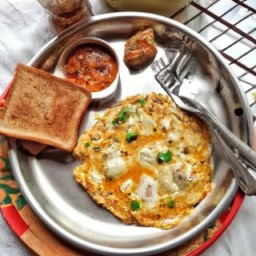

In [11]:
await SkiaUtils.ShowImage(image, 256, 256);